# This notebook is similar to the main one GHCN.ipynb, but with necessary modifications applied to analyze ERA5 data

## 1: Import libraries and dataset

In [3]:
import numpy as np
import h5py
import os
import glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
import pymannkendall as mk
import scipy 
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
# Import ERA5 daily max temperature (2m surface temp)
# The data can be downloaded from  https://cds.climate.copernicus.eu/#!/search?text=ERA5&type=dataset

# The daily data array (3d-array: lat*lon*time) should be stored to numpy array (x) for the remainder of the analysis
# presented in this paper.

## 2: Compute volatility

In [ ]:
## The below snippet is for the calculation of:
## (1) Extreme volatility (volatility_95p)
## (2) Directionality of volatility (volatility_dir)
## (3) Timing of extreme volatility (julian_day)

In [8]:
import warnings
with warnings.catch_warnings(record=True):
    
    years = np.arange(1950, 2020)
    date = pd.date_range(start='01/01/1950', end='12/31/2019')

    volatility_95p = np.empty([261, 611, 70])
    volatility_95p[:] = np.nan
    julian_day = np.empty([261, 611])
    julian_day[:] = np.nan
    volatility_dir = np.empty([261, 611, 70])
    volatility_dir[:] = np.nan

    for lat in range(d.shape[0]):
        for lon in range(d.shape[1]):
        
            v = pd.DataFrame(columns= ['date', 'day', 'month', 'year', 'volatility', 'volatility_raw'], 
                         index= list(range(len(date))))
            v['date'] = date
            v['day'] = v.date.dt.day
            v['month'] = v.date.dt.month
            v['year'] = v.date.dt.year
        
            x = d[lat,lon,:]
            x = x[0:25567]
            v['volatility'].iloc[1:] = abs(x[1:] - x[:-1])
            v['volatility'] = v['volatility'].astype(float)
            v['volatility_raw'].iloc[1:] = x[1:] - x[:-1]
            v['volatility_raw'] = v['volatility_raw'].astype(float)
        
            for y in range(len(years)):
                dummy= v[v['year']== years[y]]
                volatility_95p[lat,lon,y] = np.nanpercentile(dummy['volatility'],95) 
                xx= dummy['volatility_raw']
                xx= xx[abs(xx) > np.nanpercentile(abs(xx), 95)]
                volatility_dir[lat,lon,y] = np.sum(xx >0) / len(xx)
                
        climatology = v.groupby(by= ['month', 'day'], dropna=False).mean()
        if (np.sum(np.isnan(climatology['volatility'])) < climatology.shape[0]):
            julian_day[lat,lon] = np.nanargmax(climatology['volatility'])        

## 3: Climatology of volatility (Map)

/var/folders/7w/nnzrfjfj5gz9zc9frrbd74v00000gp/T/ipykernel_33355/1785822541.py:14: RuntimeWarning: Mean of empty slice
  plot = plt.pcolormesh(gridlons, gridlats, np.flipud(np.nanmean(volatility_95p, axis= 2)),


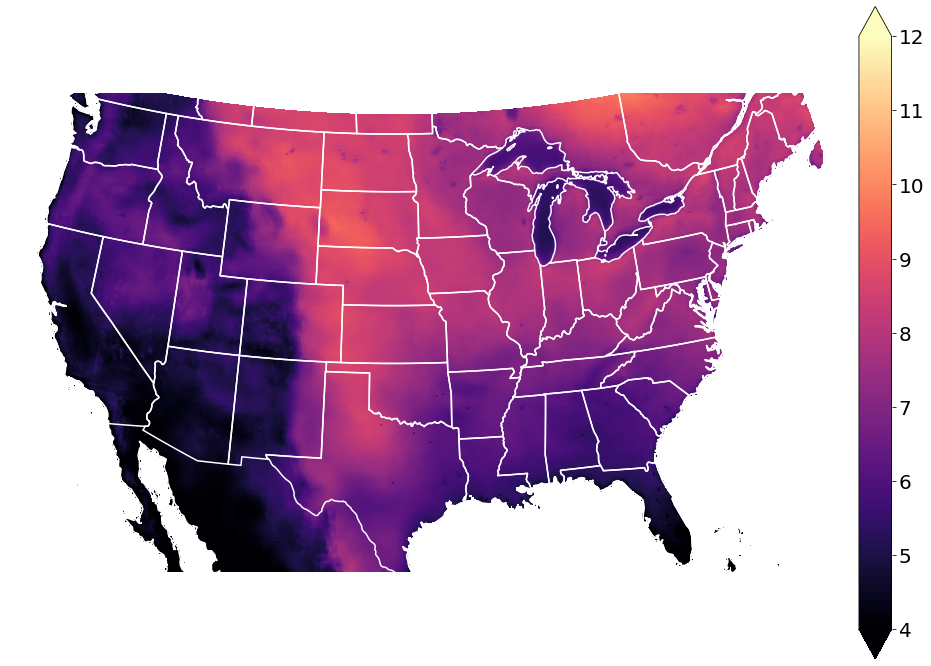

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor= 'white', linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor= 'white', linewidth=1.5)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

gridlons= np.arange(-126,-64.9,0.1)
gridlats= np.arange(24,50.1,0.1)
plot = plt.pcolormesh(gridlons, gridlats, np.flipud(np.nanmean(volatility_95p, axis= 2)), 
                      transform=crs.PlateCarree(), cmap= 'magma', vmin= 4, vmax= 12)

font = {'family':'serif','weight':'bold', 'size': 16}

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both')
cbar.ax.tick_params(labelsize=20) 

plt.savefig('.../Results/Figures/ERA5_Climatology_Volatility95p_1950_2019.jpeg'
            ,dpi=600)

plt.show()

## 4: Directionality of volatility (Map)

<ipython-input-35-f08fcc401c6a>:15: RuntimeWarning: Mean of empty slice
  data = np.nanmean(volatility_dir, axis=2)


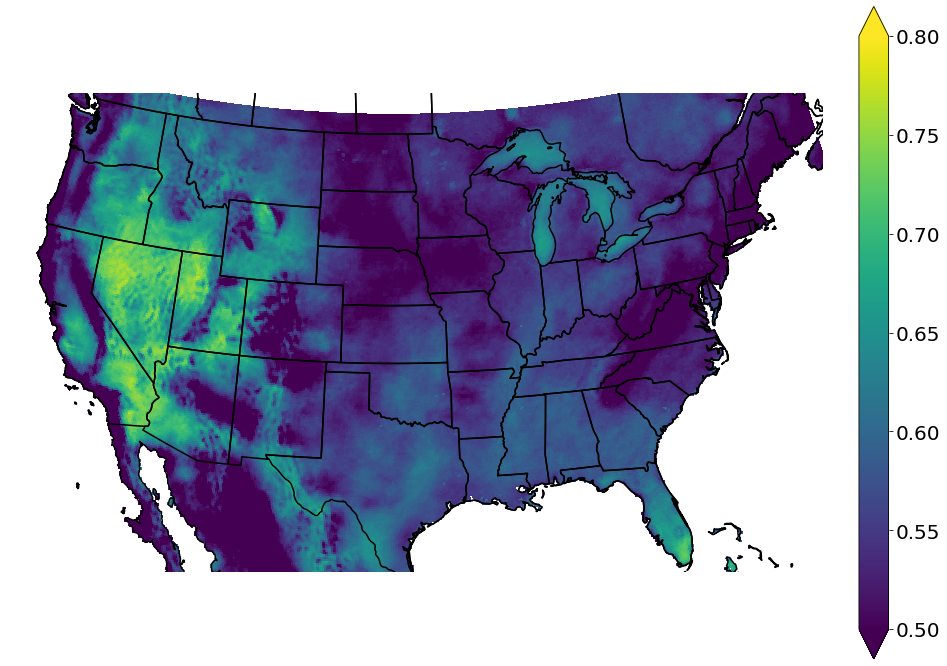

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor= 'black', linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor= 'black', linewidth=1.5)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

gridlons= np.arange(-126,-64.9,0.1)
gridlats= np.arange(24,50.1,0.1)

data = np.nanmean(volatility_dir, axis=2)
data = 1 - data

plot = plt.pcolormesh(gridlons, gridlats, np.flipud(data), transform=crs.PlateCarree(), 
                      cmap='viridis', vmin= 0.5, vmax= 0.8)

font = {'family':'serif','weight':'bold', 'size': 16}

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both')
cbar.ax.tick_params(labelsize=20) 

plt.savefig('.../Results/Figures/ERA5_directionality_1950_2015.jpeg'
            ,dpi=600)

plt.show()

## 5: Compute Trends

In [34]:
trend_pv = np.empty([261, 611])
trend_pv[:] = np.nan

trend_slope = np.empty([261, 611])
trend_slope[:] = np.nan

for lat in range(trend_pv.shape[0]):
    for lon in range(trend_pv.shape[1]):
         
            x = volatility_95p[lat,lon,:]
            if (~np.isnan(x[0])):
                result = mk.original_test(x)
                trend_pv[lat,lon] = result.p
                trend_slope[lat,lon] = result.slope    

In [36]:
# compute the adjusted alpha (signifcance level) after accounting for multiplicity
x = np.sort(trend_pv.flatten())
y = (np.arange(1, len(x)+1)/len(x))*0.05
alpha_new = max(x[x<y])
alpha_new

7.674831080017874e-05

## 6: Trends (Map)

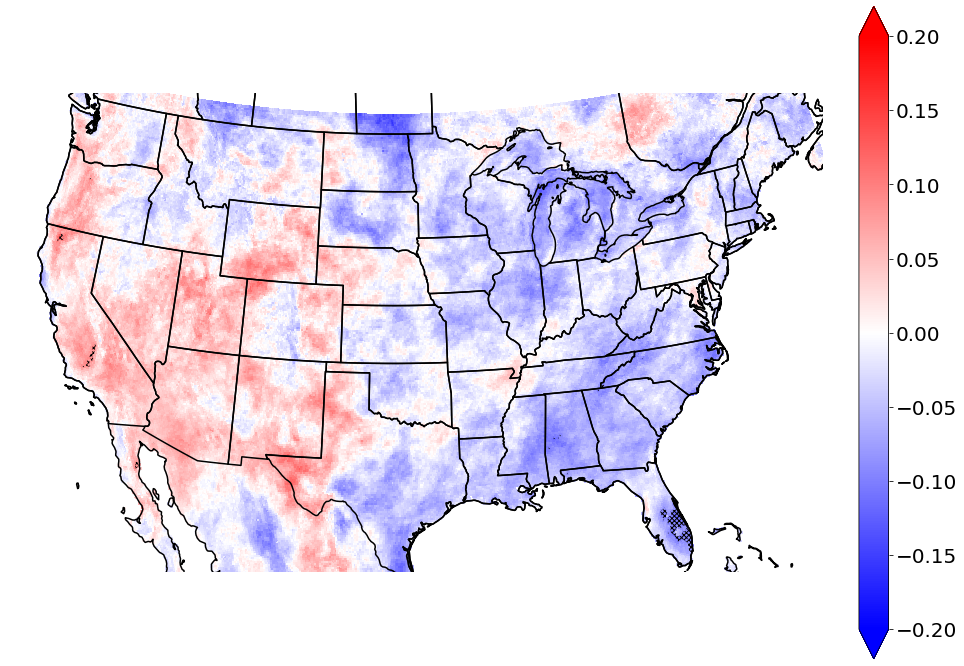

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor= 'black', linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor= 'black', linewidth=1.5)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

gridlons= np.arange(-126,-64.9,0.1)
gridlats= np.arange(24,50.1,0.1)

trend_mat = trend_slope * 10

plot = plt.pcolormesh(gridlons, gridlats, np.flipud(trend_mat), 
                     transform=crs.PlateCarree(), cmap= 'bwr', vmax= 0.2, vmin= -0.2)

ax.contourf(gridlons, gridlats, np.flipud(trend_pv <= alpha_new), transform=crs.PlateCarree(), colors='none', levels=[.5,1.5],
    hatches=[5*'x',5*'x'])

font = {'family':'serif','weight':'bold', 'size': 16}

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both')
cbar.ax.tick_params(labelsize=20) 

plt.savefig('.../Results/Figures/ERA5_trend_1950_2015.jpeg'
            ,dpi=600)

plt.show()

In [42]:
# save results
np.save('.../Results/ERA5_volatility_95p', volatility_95p)
np.save('.../Results/ERA5_julian_day',julian_day)
np.save('.../Results/ERA5_volatility_dir',volatility_dir)
np.save('.../Results/ERA5_trend_slope',trend_slope)
np.save('.../Results/ERA5_trend_p-value',trend_pv)